## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small, MobileNet, InceptionV3
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

**Gloabal Variables**

In [2]:
dir_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
img_shape = (224, 224)

## Build Functions
create the necessary functions

In [3]:
# used to preprocessing the image
def prepare_image(file):
    img = image.load_img(file, target_size=img_shape)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

### Read the files from each dirctory

In [4]:
directories = os.listdir(dir_path) # read the folders

files = [] # save all images for each folder
labels = [] # set the name for each image
# read files for each directory
for folder in directories:
    
    file_list = glob.glob(dir_path + '/'+ folder + '/*')
    labels.extend([folder for l in file_list])
    files.extend(file_list)
    
len(files), len(labels)

(1578, 1578)

### Remove masked image from files

In [5]:
# create two lists to hold only non-masked images and label
sel_files = []
sel_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        sel_files.append(file)
        sel_labels.append(label)

    
len(sel_files), len(sel_labels)

(780, 780)

### Prepare the images

In [6]:
# dictionary holds list of images and for each one has its target/label
images = {
    'image': [], 
    'target': []
}

for i, (file, label) in enumerate(zip(sel_files, sel_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)


### Prepare the target for splitting

In [7]:
# convert lists to arrays 
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


**Split the data to train and test**

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((702, 224, 224, 3), (78, 224, 224, 3), (702,), (78,))

### Build the Model

In [9]:
from tensorflow.keras.applications import EfficientNetB7
base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(*img_shape, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

inc_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
inc_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

# inc_model.summary()

258088960/258076736 [==============================] - 8s 0us/step


### Train the model

In [10]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = inc_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/100
22/22 [==============================] - 35s 514ms/step - loss: 0.9862 - sparse_categorical_accuracy: 0.5698 - val_loss: 0.9797 - val_sparse_categorical_accuracy: 0.5897


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
22/22 [==============================] - 6s 257ms/step - loss: 0.7098 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.8778 - val_sparse_categorical_accuracy: 0.6923
Epoch 3/100
22/22 [==============================] - 6s 258ms/step - loss: 0.5624 - sparse_categorical_accuracy: 0.7821 - val_loss: 0.8259 - val_sparse_categorical_accuracy: 0.7051
Epoch 4/100
22/22 [==============================] - 6s 255ms/step - loss: 0.4612 - sparse_categorical_accuracy: 0.8490 - val_loss: 0.8440 - val_sparse_categorical_accuracy: 0.6795
Epoch 5/100
22/22 [==============================] - 6s 255ms/step - loss: 0.4376 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.6904 - val_sparse_categorical_accuracy: 0.7564
Epoch 6/100
22/22 [==============================] - 6s 254ms/step - loss: 0.3298 - sparse_categorical_accuracy: 0.8875 - val_loss: 0.8111 - val_sparse_categorical_accuracy: 0.6282
Epoch 7/100
22/22 [==============================] - 6s 258ms/step - loss: 0.3671 - sparse_cate

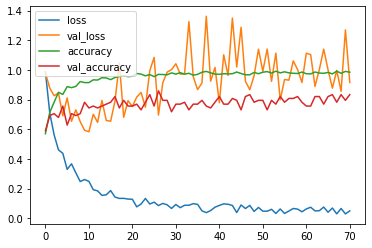

In [11]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

### Evaluate the model

In [12]:
inc_model.evaluate(x=X_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 1s 173ms/step - loss: 0.9154 - sparse_categorical_accuracy: 0.8333


[0.9153633117675781, 0.8333333134651184]

### Make the last 100 layers as trainable

In [13]:

for layer in inc_model.layers[720:]:
    layer.trainable = True
    
inc_model.compile(optimizer=optimizers.RMSprop(.0001), loss = losses.sparse_categorical_crossentropy, metrics=[metrics.SparseCategoricalAccuracy()])

inc_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [14]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_2.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = inc_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/100
22/22 [==============================] - 32s 542ms/step - loss: 0.6864 - sparse_categorical_accuracy: 0.8604 - val_loss: 1.1631 - val_sparse_categorical_accuracy: 0.8077
Epoch 2/100
22/22 [==============================] - 7s 317ms/step - loss: 0.2382 - sparse_categorical_accuracy: 0.9430 - val_loss: 0.9961 - val_sparse_categorical_accuracy: 0.7821
Epoch 3/100
22/22 [==============================] - 7s 318ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.9630 - val_loss: 1.0037 - val_sparse_categorical_accuracy: 0.7821
Epoch 4/100
22/22 [==============================] - 7s 318ms/step - loss: 0.0863 - sparse_categorical_accuracy: 0.9672 - val_loss: 1.0663 - val_sparse_categorical_accuracy: 0.7821
Epoch 5/100
22/22 [==============================] - 7s 321ms/step - loss: 0.1006 - sparse_categorical_accuracy: 0.9630 - val_loss: 1.0540 - val_sparse_categorical_accuracy: 0.8205
Epoch 6/100
22/22 [==============================] - 7s 320ms/step - loss: 0.0486 - sparse_cat

### Evaluate the model

In [15]:
inc_model.evaluate(x=X_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 1s 169ms/step - loss: 0.9806 - sparse_categorical_accuracy: 0.8462


[0.9806264042854309, 0.8461538553237915]

### Predict the model

In [16]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = inc_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

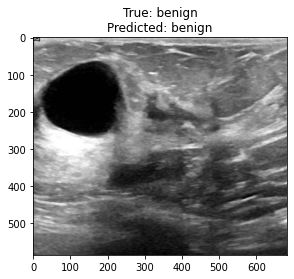

In [17]:
predict_image(dir_path + 'benign/benign (10).png', 'benign')

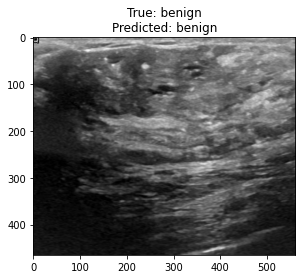

In [18]:
predict_image(dir_path + 'benign/benign (85).png', 'benign')

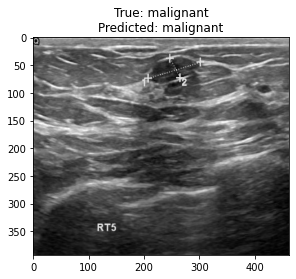

In [19]:
predict_image(dir_path + 'malignant/malignant (10).png', 'malignant')

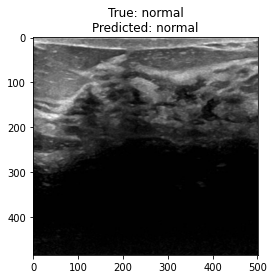

In [20]:
predict_image(dir_path + 'normal/normal (10).png', 'normal')